## Imports

In [1]:
from pathlib import Path
import pandas as pd
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video
import glob
from src.plots import *
from make_pooled_datasets import *

## Configurations

In [2]:
configFile = Path('configs/3T_NIST_T1maps.json')
data_folder_name = '3T_NIST_T1maps'
output_gif_folder = Path("plots/01-wholedataset_gif_NIST/")
output_gif_name = 'NIST.gif'

## Download datasets

In [3]:
if not Path(data_folder_name).exists():
    make_pooled_dataset(configFile, data_folder_name)

## Create and display GIF


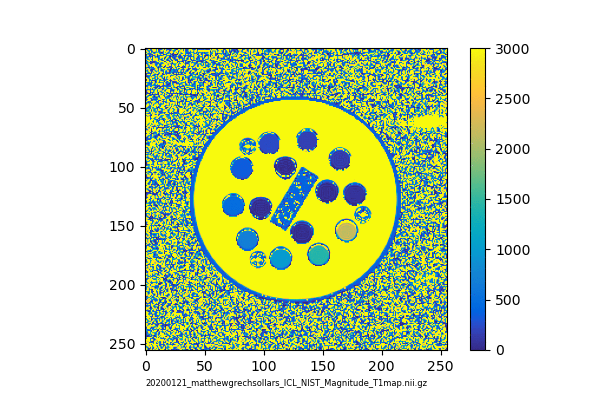

In [4]:
fig = plt.figure()

#Set background color to white
fig.set_facecolor("w")

# Set scalebar range
vmin = 0
vmax = 3000

with open(configFile) as json_file:
    configJson = json.load(json_file)

ims = []

for dataset_name in configJson:
    for key1 in configJson[dataset_name]:
        if key1 == 'datasets':
            for key2 in configJson[dataset_name][key1]:         
                
                # Load T1 image data
                t1_file = configJson[dataset_name]['datasets'][key2]['imagePath']
                t1 = nib.load(Path(data_folder_name) / t1_file)
                t1_volume = t1.get_fdata() 

                # Handle 2D vs 3D volume case
                dims = t1_volume.shape
                if (len(dims) == 2) or (np.min(dims) == 1):
                    im = plt.imshow(np.rot90(t1_volume), cmap=parula_map, animated=True, vmin = vmin, vmax = vmax)
                else:
                    index_smallest_dim = np.argmin(dims)
                    numberOfSlices = dims[index_smallest_dim]
                    midSlice = int(np.round(numberOfSlices/2))

                    if index_smallest_dim == 0:
                        im = plt.imshow(np.rot90(np.squeeze(t1_volume[midSlice,:,:])), cmap=parula_map, animated=True, vmin = vmin, vmax = vmax)
                    elif index_smallest_dim == 1:
                        im = plt.imshow(np.rot90(np.squeeze(t1_volume[:,midSlice,:])), cmap=parula_map, animated=True, vmin = vmin, vmax = vmax)
                    elif index_smallest_dim == 2:
                        im = plt.imshow(np.rot90(np.squeeze(t1_volume[:,:,midSlice])), cmap=parula_map, animated=True, vmin = vmin, vmax = vmax)
                
                # Add filename text to image
                ttl = plt.text(0, 280, Path(t1_file).name, fontsize=6, horizontalalignment='left', verticalalignment='top')
                
                ims.append([im, ttl])

# Save all images to GIF
plt.colorbar()
plt.clim(vmin,vmax)

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False,repeat_delay=1000)

output_gif_folder.mkdir(parents=True, exist_ok=True)
ani.save(output_gif_folder / output_gif_name, dpi=100, writer='imagemagick')

plt.close()

show_gif(output_gif_folder / output_gif_name)